# TD4: Sparse dictionary decomposition

In this session, we will solve an inverse problem with a Lasso regularization. First, we will do so with a gradient descent.

## Mathematical framework
A signal $y$ is can be decomposed in a dictionary $D$:
$$
    y = Dx
$$
Our aim is to find a sparse decomposition of $y$ in $D$, so we want to solve this inverse problem and find $x$ as sparse as possible:
$$
    \texttt{minimize} \quad \mathcal L(x) = \frac{1}{2}\|y - Dx\|_2^2 + \lambda \|x\|_1
$$
Here, $D$ will be a dictionary of wavelet, meaning that $x$ is a $(T, p)$ matrix, where $T$ is the time and $p$ is the number of wavelets in the dictionary, and we have:
$$
    \forall t \in [0,\dots,T-1], \quad Dx(t) = \sum_{\psi \in D} x \ast \psi (t)
$$

## Input Data
We will use a piano note as input data $y$, which is in file `piano_4s_4096.npy`

## Dictionary of wavelets
$D$ is a dictionary of Morlet wavelets. A Morlet wavelet is defined as:
$$
    \hat \psi_{\omega_0, \sigma}(\omega) = e^{\frac{-(\omega - \omega_0)^2}{2\sigma^2}} - \beta_{\omega_0, \sigma} e^{\frac{-\omega^2}{2\sigma^2}} 
$$
with $\beta_{\omega_0, \sigma}$ such that $\hat \psi_{\omega_0, \sigma}(0) = 0$



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

from morlet_filters import morlet_1d

def figure(width=12, height=6, **kwargs): plt.figure(figsize=(width, height), **kwargs)

## Load audio file

##### True Signal

In [2]:
y = np.load("piano_4s_4096.npy")
y = y / np.max(np.abs(y))  # renormalize so maximum absolute value is 1
sr = 4096
Audio(y, rate=sr)

## Define a Morlet Wavelet
At this point, we do not know anything but $y_0$ and $h$, and want to reconstruct $x_0$

In [3]:
T = np.size(y)
Q = 12  # number of wavelet per octave
J = int(np.log(T))  # number of octaves, note that some wavelets here may be to low for us to hear

A Morlet wavelet function has been define in the file `morlet_filters.py`, you can use the function `morlet_1d` to define a morlet filter centered arround frequency $\omega_0$ as shown below. $Q$ is the number of wavelet per octave, here we take $Q=12$ because there are $12$ half-tone per octave (for better precision we could use $Q=24$).

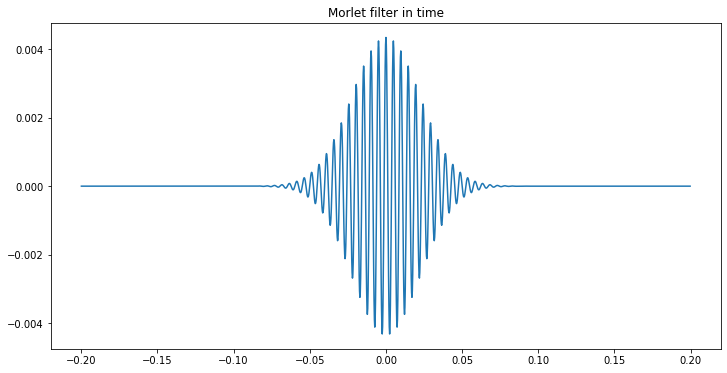

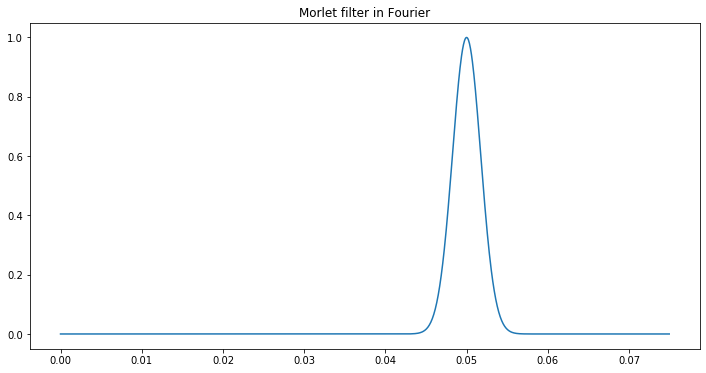

In [4]:
omega0 = .05
morlet_hat = morlet_1d(T, omega0, Q)
morlet = np.fft.ifft(morlet_hat)

display(Audio(np.fft.fftshift(np.real(morlet)), rate=2**12))


dr = int(.2 * sr)  # Display radius, for following plot
figure()
plt.plot(np.arange(-dr, dr)/sr, np.fft.fftshift(np.real(morlet))[T//2 - dr:T//2 + dr])
plt.title("Morlet filter in time")
plt.show()

figure()
freq = np.fft.fftfreq(T)
mask = np.logical_and(freq >= 0, freq <= 1.5 * omega0)
plt.plot(freq[mask], np.abs(morlet_hat)[mask])
plt.title("Morlet filter in Fourier")
plt.show()

In [5]:
max_freq = 0.475
psi_hat = [morlet_1d(T, max_freq * np.power(2, j/Q), Q) for j in range(J*Q)]
psi_hat = np.stack(psi_hat, axis=0)
print("Shape (p, T) of the dictionary: {}".format(psi_hat.shape))

Shape (p, T) of the dictionary: (108, 16384)


# Your time to work !

### Question 0: Display the wavelet dictionary

#### 0.a/ On a single graph with frequencies from 0 to 0.5 on x-axis, display the modulus of all wavelets in the dictionary

#### 0.b/ Still in Fourier, display for each frequency $\omega$ the energy $\mathcal E(\omega) = \sum_{\psi \in D} |\psi(\omega)|^2$ of the dictionary at that frequency.
Note: The ratio $\max_\omega \mathcal E(\omega) / \min_\omega \mathcal E(\omega)$ is linked to the ability to invert the dictionary transform: the closer to $1$ the better.

### Question 1: Fill the code for functions `reconstruction_error`, `l1_norm` and  `loss`

#### 1.a/ `reconstruction_echo` takes $y$ as input and returns $\|y_0 - D x\|_2^2$

In [6]:
def reconstruction_error(x):
    """
    Compute the echo of reconstruction x and compares it to true measurement y0
    
    Inputs:
    ------
    x : numpy array of size (p, T)
        current reconstruction

    Output:
    -------
    err: float
        Squarred error between true measurement and echo of current x
    """
    raise NotImplementedError

#### 1.b/ `l1_norm` takes $x$ as input and returns $\| x \|_1$

In [7]:
def l1_norm(x):
    """
    Compute the L1 norm of x
    
    Input:
    ------
    x : numpy array of size (p, T)
        current reconstruction

    Output:
    -------
    l1_norm: float
        L1 norm of x
    """
    raise NotImplementedError

#### 1.c/ `loss` takes $x$ and $\lambda$ as input and returns $\mathcal L(x)$ as defined at the beginning of the notebook

In [8]:
def loss(x, la):
    """
    Compute the regularized reconstruction loss
    
    Input:
    ------
    x : numpy array of size (p, T)
        current reconstruction
    la : float
        weight given to regularization in the loss

    Output:
    -------
    loss: float
        regularized reconstruction loss
    """
    raise NotImplementedError

### Question 2: What are the gradients with respect to $x$ ?
#### 2.a/ Gradient of $\|y_0 - Dx\|_2^2$ with respect to $x$ ?

#### 2.b/ Gradient of $\| x \|_1$ with respect to $x$ ?

#### 2.c/ Gradient of $\mathcal L(x)$ with respect to $x$ ?


### Question 3: Fill the gradient functions of `reconstruction_echo`, `wavelet_l1_norm` and  `loss`, respectively called `gradient_reconstruction_echo`, `gradient_wavelet_l1_norm` and  `gradient_loss`

In [9]:
def gradient_reconstruction_error(x):
    """
    gradient of reconstruction_echo(x) with respect to x
    """
    raise NotImplementedError

In [10]:
def gradient_l1_norm(x):
    """
    gradient of wavelet_l1_norm(x) with respect to x
    """
    raise NotImplementedError

In [11]:
def loss_gradient(x):
    """
    gradient of loss(x) with respect to x
    """
    raise NotImplementedError

## Now, let us minimize the loss function in order to reconstruct $x$ from $y_0$

In [12]:
x = np.random.randn(T)

### Question 4: From this initialization, set a lambda and iteratively take gradient steps

#### 4.a/ Define the function `step` which takes as input $x_i$ (reconstruction at step $i$), $gL$ (which is the gradient of the loss with respect to $x_i$) and a learning rate `lr` and returns $x_{i+1}$

In [13]:
def step(x, gL, lr):
    raise NotImplementedError

#### 4.b/ Chose a $\lambda$ and a learning rate, and iterate this gradient step. What happens ?

### Question 5: Let's start again with $\|x\|_{1, \epsilon} = \sum_i \sqrt{x_i^2 + \epsilon^2}$ instead of $\|x\|_1$